In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import datetime

In [ ]:
import tensorflow as tf

cifar = tf.keras.datasets.cifar100
(x_train, y_train), (x_test, y_test) = cifar.load_data()
model = tf.keras.applications.ResNet50(
    include_top=True,
    weights=None,
    input_shape=(32, 32, 3),
    classes=100,)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
model.fit(x_train, y_train, epochs=5, batch_size=64)

# Download data from kaggle

In [2]:
!pip install kaggle


from google.colab import files
files.upload()




Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sayidheykal","key":"e6e9a20922c6182e48e1cbac69a56342"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d shakyadissanayake/oily-dry-and-normal-skin-types-dataset

Dataset URL: https://www.kaggle.com/datasets/shakyadissanayake/oily-dry-and-normal-skin-types-dataset
License(s): Apache 2.0
 96% 120M/124M [00:04<00:00, 34.9MB/s]
100% 124M/124M [00:04<00:00, 26.6MB/s]


In [4]:
!unzip /content/oily-dry-and-normal-skin-types-dataset.zip -d /content/oily-dry-and-normal-skin-types-dataset


Archive:  /content/oily-dry-and-normal-skin-types-dataset.zip
  inflating: /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/README.dataset.txt  
  inflating: /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/test/dry/dry_10583924a54a7cbcf5d0_jpg.rf.7c4cb0ac9522f3a0faaf230527e1abe9.jpg  
  inflating: /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/test/dry/dry_1d3b1b41c06745c89fb6_jpg.rf.9fe7b2181a36c2b6f67744be1af2fdd7.jpg  
  inflating: /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/test/dry/dry_2e2591d4cf31b8e024a6_jpg.rf.e8a8db4db95cd0a0df0275d75fcd87a0.jpg  
  inflating: /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/test/dry/dry_304ff9ea442145481f67_jpg.rf.26e1ca5ca2eb32f5c89509c670ca967a.jpg  
  inflating: /content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/test/dry/dry_33489ccedfbd77039b4d_jpg.rf.bff22d94ad08b5402f1feb8e304a7368.jpg  
  inflating: /content/oily-dry-

# Generate data

In [5]:
# defined directories
# -------------------

# base working directory
base_dir = '/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/'

# training data directory
train_dir = base_dir + 'train'

 # validation data directory
valid_dir = base_dir + 'valid'

# test data directory
test_dir = base_dir + 'test'

train_dir, valid_dir, test_dir

('/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train',
 '/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/valid',
 '/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/test')

# EDA

In [6]:
def count_files_and_directories(path):
    file_count = 0
    directory_count = 0

    for dirpath, dirnames, filenames in os.walk(path):
        # Count the number of files in the current directory
        file_count += len(filenames)
        # Count the number of subdirectories in the current directory
        directory_count += len(dirnames)

    return file_count, directory_count

num_train, num_train_labels = count_files_and_directories(train_dir)
num_valid, num_valid_labels = count_files_and_directories(valid_dir)
num_test, num_test_labels = count_files_and_directories(test_dir)

all, _ = count_files_and_directories(base_dir)

print(f'number of images: {all}\n-------------------\n')
print(f'train data length: {num_train}\nNum of train labels: {num_train_labels}\npercentage: {round(num_train/all*100,2)} %\n')
print(f'valid data length: {num_valid}\nNum of train labels: {num_valid_labels}\npercentage: {round(num_valid/all*100,2)} %\n')
print(f'test data length: {num_test}\nNum of test labels: {num_test_labels}\npercentage: {round(num_test/all*100,2)} %\n')

number of images: 3153
-------------------

train data length: 2756
Num of train labels: 3
percentage: 87.41 %

valid data length: 262
Num of train labels: 3
percentage: 8.31 %

test data length: 134
Num of test labels: 3
percentage: 4.25 %



## Visualization Data

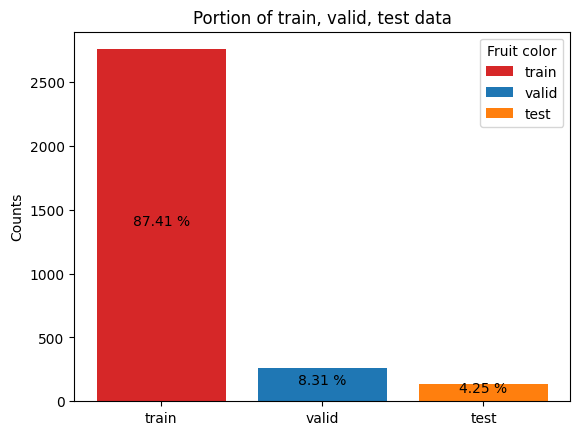

In [7]:
fig, ax = plt.subplots()

labels = ['train', 'valid', 'test']
counts = [num_train, num_valid, num_test]
percentages = [num_train/all, num_valid/all, num_test/all]
bar_colors = ['tab:red', 'tab:blue', 'tab:orange']

# Create horizontal bar chart
bars = ax.bar(labels, counts, color=bar_colors, label=labels)

# Add labels to bars with customizations
ax.bar_label(bars, labels=[f'{round(v * 100, 2)} %' for v in percentages], padding=3, fontsize=10, label_type='center')

# Set labels
ax.set_ylabel('Counts')
ax.set_title('Portion of train, valid, test data')
ax.legend(title='Fruit color')

# Show the plot
plt.show()


In [8]:
# define dict of number of dry, oil, and normal skin types images
num_dry_img = {
    'train' : len(os.listdir(os.path.join(train_dir, 'dry'))),
    'valid' : len(os.listdir(os.path.join(valid_dir, 'dry'))),
    'test'  : len(os.listdir(os.path.join(test_dir, 'dry'))),
}

num_oily_img = {
    'train' : len(os.listdir(os.path.join(train_dir, 'oily'))),
    'valid' : len(os.listdir(os.path.join(valid_dir, 'oily'))),
    'test'  : len(os.listdir(os.path.join(test_dir, 'oily'))),
}

num_normal_img = {
    'train' : len(os.listdir(os.path.join(train_dir, 'normal'))),
    'valid' : len(os.listdir(os.path.join(valid_dir, 'normal'))),
    'test'  : len(os.listdir(os.path.join(test_dir, 'normal'))),
}


print(f'dry images: {num_dry_img}')
print(f'normal images: {num_dry_img}')
print(f'oily images: {num_dry_img}')

dry images: {'train': 652, 'valid': 71, 'test': 35}
normal images: {'train': 652, 'valid': 71, 'test': 35}
oily images: {'train': 652, 'valid': 71, 'test': 35}


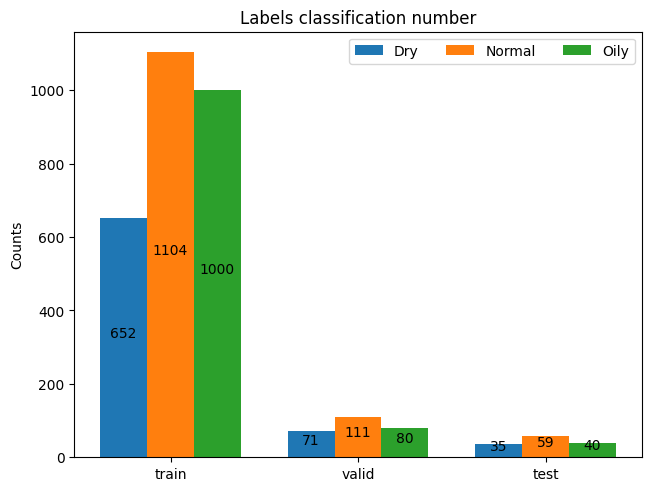

In [9]:
# draw diagram started here
labels = ("train", "valid", "test")
label_names = {
    'Dry': tuple(num for num in num_dry_img.values()),
    'Normal': tuple(num for num in num_normal_img.values()),
    'Oily': tuple(num for num in num_oily_img.values()),
}

x = np.arange(len(labels))  # the label locations
width = 0.25 # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in label_names.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, label_type='center')
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Labels classification number')
ax.set_xticks(x + width, labels)
ax.legend(loc='upper right', ncols=3)
# ax.set_ylim(0, 250)

plt.show()

# Data Preprocessing

In [10]:
# create imageDataGenerator instance
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
                                   )
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# create Generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical'
                                                    )

validation_generator = validation_datagen.flow_from_directory(valid_dir,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical'
                                                    )

validation_generator = validation_datagen.flow_from_directory(test_dir,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical'
                                                    )

Found 2756 images belonging to 3 classes.
Found 262 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


# Build model

In [12]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                      

In [13]:
def create_model_with_preTrained(pre_trained):
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Flatten()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dense(512, activation='relu')(x)
  x = BatchNormalization()(x)
  predictions = Dense(3, activation='softmax')(x)

  return Model(inputs=base_model.input, outputs=predictions)

# create a model
model = create_model_with_preTrained(base_model)


## Find the best fit Learning rate

In [14]:
class LearningRateFinder(tf.keras.callbacks.Callback):
    def __init__(self, min_lr=1e-8, max_lr=1e-4, steps_per_epoch=100, epochs=1):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_steps = steps_per_epoch * epochs
        self.lr_mult = (max_lr / min_lr) ** (1 / self.total_steps)
        self.step = 0
        self.history = {}

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.step += 1
        lr = self.min_lr * (self.lr_mult ** self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)

        # Record the learning rate and the loss
        self.history.setdefault('lr', []).append(lr)
        self.history.setdefault('loss', []).append(logs.get('loss'))

    def on_train_end(self, logs=None):
        tf.keras.backend.set_value(self.model.optimizer.lr, self.min_lr)


In [15]:
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [16]:
# set callbacks for learning rate finder
steps_per_epoch = train_generator.samples // train_generator.batch_size
lr_finder = LearningRateFinder(steps_per_epoch=steps_per_epoch)

# Train model
def train_model(epochs, lr=0.001, steps_per_epoch=None, callbacks=None):
  # Compile model
  model.compile(optimizer=Adam(learning_rate=lr),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  # return train history
  return model.fit(train_generator,
                  epochs=epochs,
                  batch_size=32,
                  verbose=2,
                  steps_per_epoch=steps_per_epoch,
                  validation_data=validation_generator,
                  validation_steps=validation_generator.samples // validation_generator.batch_size,
                  callbacks=callbacks
                  )

# call train model for finding the learning rate
train_model(epochs=1, callbacks=lr_finder)

87/87 - 58s - loss: 2.1118 - accuracy: 0.3240 - val_loss: 1.1361 - val_accuracy: 0.3047 - 58s/epoch - 668ms/step


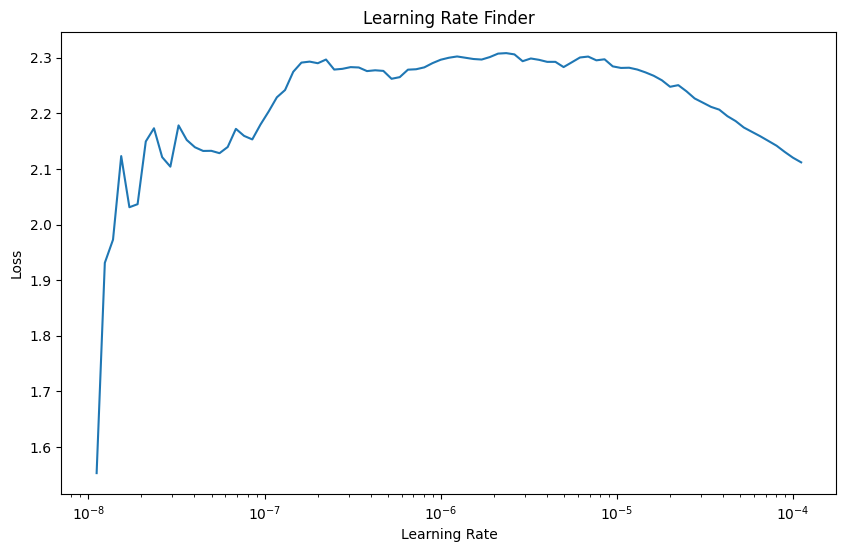

In [17]:
# plot the learning_rate history

lrs = lr_finder.history['lr']
losses = lr_finder.history['loss']

plt.figure(figsize=(10, 6))
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate Finder')
plt.show()


# Set Callbacks

In [18]:

# tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# model checkpoint
trial_number = 2
filepath_checkpoint = f'/tmp/ckpt/{trial_number}/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath_checkpoint + 'model-{epoch:02d}-{accuracy:.2f}-{val_accuracy:.2f}.h2',
    verbose=1,
    monitor='accuracy',
    save_best_only=True
)

# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(f'/run/log/log-{trial_number}.csv')

# Train model


In [ ]:
LEARNING_RATE = 1e-5
EPOCHS = 10

# train
history = train_model(epochs=EPOCHS,
                      lr=LEARNING_RATE,
                      steps_per_epoch=steps_per_epoch,
                      callbacks=[model_checkpoint_callback, csv_logger])

Epoch 1/10

Epoch 1: accuracy improved from -inf to 0.33113, saving model to /tmp/ckpt/2/model-01-0.33-0.30.h2
86/86 - 62s - loss: 1.1603 - accuracy: 0.3311 - val_loss: 1.1274 - val_accuracy: 0.3047 - 62s/epoch - 717ms/step
Epoch 2/10

Epoch 2: accuracy improved from 0.33113 to 0.34838, saving model to /tmp/ckpt/2/model-02-0.35-0.26.h2
86/86 - 55s - loss: 1.1182 - accuracy: 0.3484 - val_loss: 1.1331 - val_accuracy: 0.2578 - 55s/epoch - 637ms/step
Epoch 3/10

Epoch 3: accuracy improved from 0.34838 to 0.35609, saving model to /tmp/ckpt/2/model-03-0.36-0.32.h2
86/86 - 55s - loss: 1.1078 - accuracy: 0.3561 - val_loss: 1.1090 - val_accuracy: 0.3203 - 55s/epoch - 639ms/step
Epoch 4/10

Epoch 4: accuracy improved from 0.35609 to 0.38289, saving model to /tmp/ckpt/2/model-04-0.38-0.31.h2
86/86 - 57s - loss: 1.1000 - accuracy: 0.3829 - val_loss: 1.1204 - val_accuracy: 0.3125 - 57s/epoch - 664ms/step
Epoch 5/10

Epoch 5: accuracy did not improve from 0.38289
86/86 - 40s - loss: 1.1035 - accurac

## Fine-Tune

In [ ]:
# Unfreeze some layers and
for layer in base_model.layers[-30:]:
    layer.trainable = True

history_ft = train_model(epochs=EPOCHS,
                      lr=LEARNING_RATE,
                      steps_per_epoch=steps_per_epoch,
                      callbacks=[model_checkpoint_callback])

# Evaluation

In [ ]:
def plot_acc_loss(history):
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # Plot training & validation loss values
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # save graph to png
  pngfile = 'acc_loss.png'
  if os.path.isfile(pngfile):
    plt.savefig('acc_loss(1).png')
  plt.savefig(f'acc_loss.png')

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  print(f'accuracy\t: {acc[len(acc)-1]}, val_accuracy\t: {val_acc[len(val_acc)-1]}')

  print(f'loss\t\t: {loss[len(loss)-1]}, val_loss\t: {val_loss[len(val_loss)-1]}')


In [ ]:
def save_csv(history, filename='model'):
  history_dict = {
      'acc' : history.history['accuracy'],
      'val_acc' : history.history['val_accuracy'],
      'loss' : history.history['loss'],
      'val_loss' : history.history['val_loss'],
  }

  import pandas as pd
  df = pd.DataFrame(history_dict)
  df.to_csv(f'{filename}.csv')
  print(f'success download file {filename}.csv')

In [ ]:
save_csv(history_ft, 'skin_type_tf_1')
files.download('skin_type_tf_1.csv')

In [ ]:
# Plot training & validation accuracy values
plot_acc_loss(history)

In [ ]:

# fine-tuned plot model
plot_acc_loss(history_ft)

# Download checkpoint file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/

!zip -r model.zip /tmp/ckpt/2/



In [ ]:
# tmp code for download csv log
files.download(f'/run/log/log-{trial_number}.csv')


In [ ]:
files.download('/content/drive/MyDrive/model.zip')